In [1]:
# NN packages
import jax
import jax.numpy as jnp
import optax
import numpy as np
import json
import os

# Visualization packages
import matplotlib.pyplot as plt

# ML Models
from LNN.models.MDOF_LNN import Modal_Damped_LNN, Modal_MLP

# Helper functions
from LNN.helpers import save_to_file, create_modal_training_data, plot_S_curves, plot_3DS_curves

from lnn_timesim import time_sim_branch, run

In [2]:
# Switch GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#### LNN

In [3]:
FREQUENCY = True
FRC = False

if FREQUENCY:
    filename='frequency_step_frequency_'
    path='LNN/Conx/modal_freq'
    start=10.0
    stop=24.0
    step=0.2
else:
    filename='amplitude_step_amplitude_'
    path='LNN/Conx/modal_amp'
    start=0.1
    stop=2.0
    step=0.1

ml_data = save_to_file(filename=filename, path=path, start=start, stop=stop, step=step, check=True)

train_data, test_data, info = create_modal_training_data(ml_data, path, split=0.2, seed=42)

Data saved to LNN/Conx/modal_freq/data.pkl
Number of files: 71

---EXAMPLE SHAPES---
pose: (2, 301, 39), vel: (2, 301, 39), acc: (2, 301, 39)
If MODAL: 2 Modes, 301 time steps per 39 points along curve
If PHYSICAL: 301 time steps per 39 points along curve
time: (301, 39), F: (39,), T: (39,), force: (2, 301, 39)
Training data shape: (820969, 2, 4), Testing data shape: (211413, 2, 4)
Samples, # of Modes, [x, dx, ddx, force]
x_train.shape: (820969, 2), dx_train.shape: (820969, 2), ddx_train.shape: (820969, 2), force_train.shape: (820969, 2)
x_test.shape: (211413, 2), dx_test.shape: (211413, 2), ddx_test.shape: (211413, 2), force_test.shape: (211413, 2)


In [4]:
mnn_settings = {
    'name': 'MNN',
    'units': 64,
    'layers': 4,
    'input_shape': 4,
    'train_batch_size': 128,
    'test_batch_size': 16,
    'shuffle': True,
    'seed': 69
    }

knn_settings = {
    'name': 'KNN',
    'units': 64,
    'layers': 4,
    'input_shape': 4,
    }

dnn_settings = {
    'name': 'DNN',
    'units': 32,
    'layers': 4,
    'input_shape': 2,
    }

lr = 1e-03
mnn_optimizer = optax.adam(lr)
knn_optimizer = optax.adam(lr)
dnn_optimizer = optax.adam(lr)
epochs = 20
show_every = 10

In [5]:
a = Modal_Damped_LNN(
    mnn_module=Modal_MLP, 
    knn_module=Modal_MLP,       
    dnn_module=Modal_MLP, 
    mnn_settings=mnn_settings,
    knn_settings=knn_settings,
    dnn_settings=dnn_settings, 
    mnn_optimizer=mnn_optimizer, 
    knn_optimizer=knn_optimizer, 
    dnn_optimizer=dnn_optimizer, 
    info=info, 
    activation=jax.nn.tanh)

# Start training LNN
results = None
_, _, _ = a.gather()

In [6]:
results_path = 'MDOF_LNN'
file_name='Modal_freq'
iter_num = 200

epochs = 20
show_every = 10

In [7]:
results = Modal_Damped_LNN.load_model(f"./LNN/{results_path}/{file_name}/Iter_{iter_num}/model.pkl")

In [8]:
pred_acc_, pred_energy = a._predict(results)

#### NOTES:
- $16.0$ Hz doesn't start - to investigate
- $18.6$ Hz fails after a few steps - to investigate

In [9]:
if not FRC:
    start=10.0
    stop=24.0
    step=0.2
else:   
    start=0.1
    stop=2.0
    step=0.1



Iter Cont     Iter Corr     Residual      Freq          Amp           Energy        Step          Beta          
0             0             2.3924e-03    23.0000       0.1000        0.0000e+00                                
0             1             1.2309e-07    23.0000       0.1000        0.0000e+00                                


/home/aax23/PyCont_release/core/logger.py:201: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.pause(0.01)


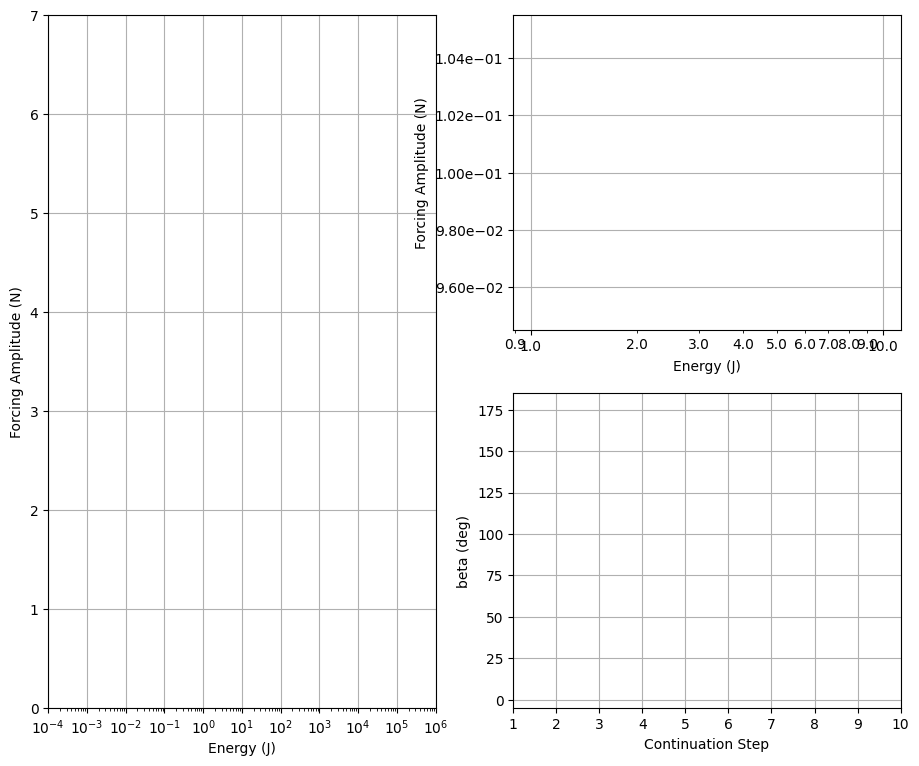

----------------------------------------------------------------------------------------------------------------
1             0             8.1722e-08    23.0000       0.1001        0.0000e+00    1.000e-04                   
1             1             3.9477e-08    23.0000       0.1001        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------


/home/aax23/PyCont_release/core/logger.py:217: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.fig.tight_layout()


2             0             1.1248e-07    23.0000       0.1002        0.0000e+00    1.000e-04                   
2             1             8.2907e-08    23.0000       0.1002        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
3             0             8.7909e-08    23.0000       0.1004        0.0000e+00    2.000e-04                   
3             1             1.5519e-07    23.0000       0.1004        0.0000e+00    2.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
4             0             7.7387e-08    23.0000       0.1008        0.0000e+00    4.000e-04                   
4             1             1.7404e-08    23.0000       0.1008        0.0000e+00    4.000e-04     0.0000        
------------------------------------------------------------------------------------------------

E0930 17:01:40.813289 2496569 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
  File "/usr/local/lib/python3.11/asyncio/events.py", line 80, in _run


ODE solver failed: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/aax23/PyCont_release/.lnn/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    handle._run()
  File "/usr/loc

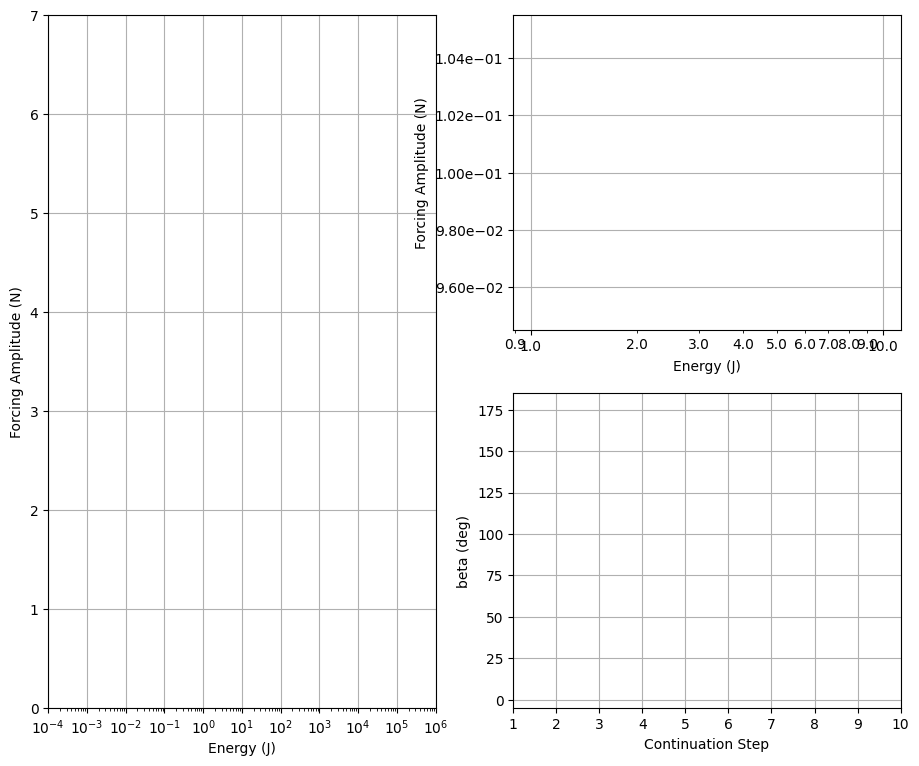

----------------------------------------------------------------------------------------------------------------
1             0             1.2191e-07    23.2000       0.1001        0.0000e+00    1.000e-04                   
1             1             1.9956e-07    23.2000       0.1001        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
2             0             6.4807e-08    23.2000       0.1002        0.0000e+00    1.000e-04                   
2             1             4.9805e-08    23.2000       0.1002        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
3             0             1.8907e-08    23.2000       0.1004        0.0000e+00    2.000e-04                   
3             1             1.5425e-07    23.2000       0.1004        0.0000e+00    2.000e-04   

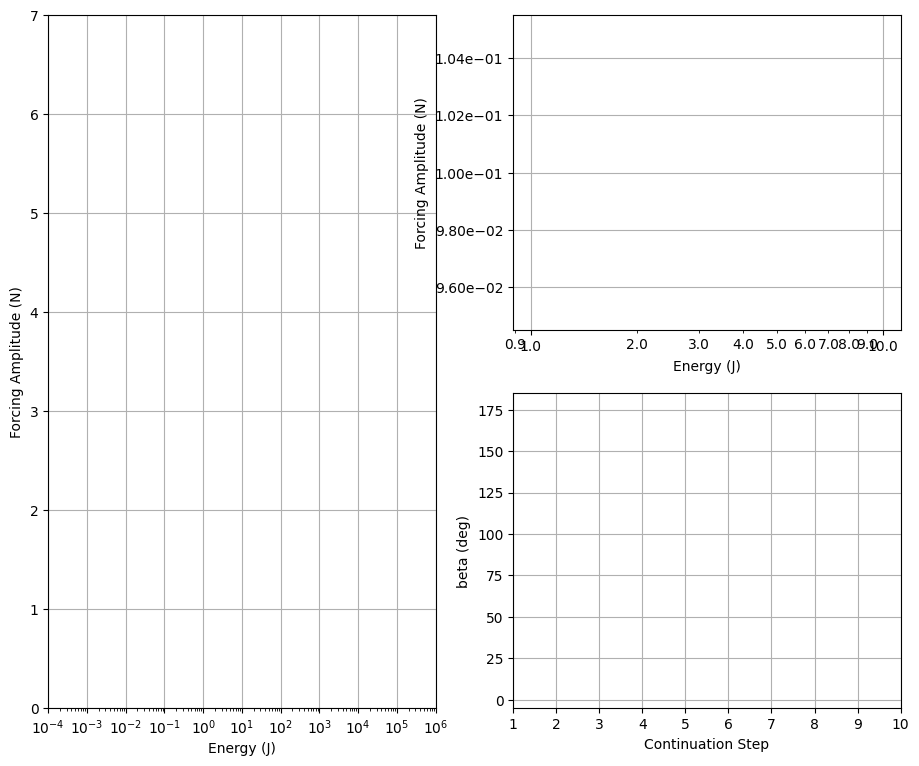

----------------------------------------------------------------------------------------------------------------
1             0             2.7869e-07    23.4000       0.1001        0.0000e+00    1.000e-04                   
1             1             7.4723e-08    23.4000       0.1001        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
2             0             1.7607e-07    23.4000       0.1002        0.0000e+00    1.000e-04                   
2             1             6.2180e-08    23.4000       0.1002        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
3             0             6.4291e-08    23.4000       0.1004        0.0000e+00    2.000e-04                   
3             1             6.4957e-08    23.4000       0.1004        0.0000e+00    2.000e-04   

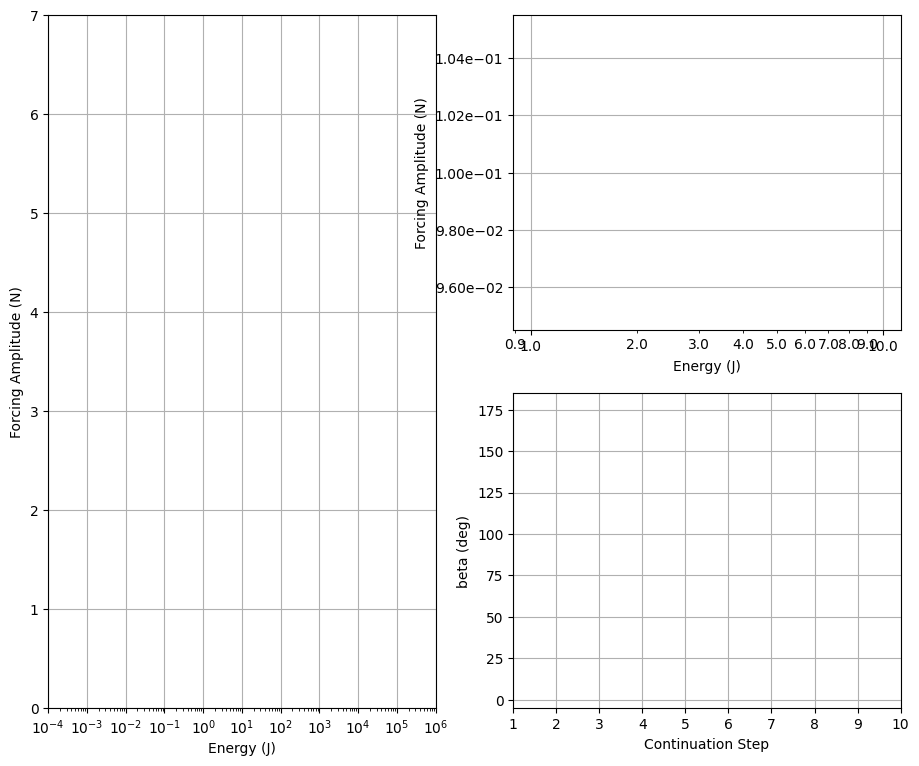

----------------------------------------------------------------------------------------------------------------
1             0             1.8427e-07    23.6000       0.1001        0.0000e+00    1.000e-04                   
1             1             1.4116e-07    23.6000       0.1001        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
2             0             4.2469e-08    23.6000       0.1002        0.0000e+00    1.000e-04                   
2             1             6.9548e-08    23.6000       0.1002        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
3             0             1.7753e-07    23.6000       0.1004        0.0000e+00    2.000e-04                   
3             1             1.2866e-07    23.6000       0.1004        0.0000e+00    2.000e-04   

In [ ]:
# FREQUENCY 
cont_params_file = 'contparameters.json'
if not FRC:
    # S-curves
    for i in np.arange(23.0, 30.0+0.1, step):
        # Open contparameters.json
        with open(cont_params_file, 'r') as file:
            data = json.load(file)
            data["continuation"]["continuation_parameter"] = "amplitude"
            # Modify forcing frequency
            data['forcing']['frequency'] = i
            # Save file
            data['Logger']['file_name'] = f'freq_step_{i:.02f}'

        # Modify contparameters.json
        with open(cont_params_file, 'w') as file:
            json.dump(data, file, indent=2)
        
        # Run simulation
        run(pred_acc=pred_acc_)
        
        # Perform time-sim post-processing
        time_sim_branch(file=f'freq_step_{i:.02f}', inplace="-i", run_bif="n", store_physical="n")
else: # FRC
    for i in np.arange(start, stop+0.1, step):
        # Open contparameters.json
        with open(cont_params_file, 'r') as file:
            data = json.load(file)
            data["continuation"]["continuation_parameter"] = "frequency"
            # Modify forcing amplitude
            data['forcing']['amplitude'] = i
            # Save file
            data['Logger']['file_name'] = f'amp_step_{i:.02f}'

        # Modify contparameters.json
        with open(cont_params_file, 'w') as file:
            json.dump(data, file, indent=2)
        
        # Run simulation
        run(pred_acc=pred_acc_)
        
        # Perform time-sim post-processing
        time_sim_branch(file=f'amp_step_{i:.02f}', inplace="-i", run_bif="n", store_physical="n")